In [1]:
import math
import torch 
from torch import nn 
from d2l import torch as d2l

自注意力<br>
用同一组词元同时充当查询、键和值<br>
具体来说，每个查询都会关注所有的键-值对并生成一个注意力输出

In [2]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

位置编码<br>
处理词元序列时，循环神经网络是逐个重复地处理词元的，而自注意力则因为并行计算而放弃了顺序操作<br>
为了使用序列的顺序信息，可以在输入表示中添加位置编码来注入绝对的或相对的位置信息

In [4]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / \
            torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
        self.P[0:, :, 0::2] = torch.sin(X)
        self.P[0:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

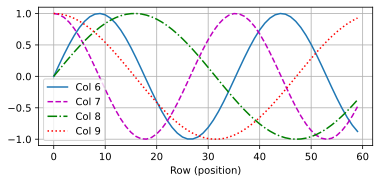

In [5]:
# 在位置嵌入矩阵P中，行代表词元在序列中的位置，列代表位置编码的不同维度
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)', 
         figsize=(6, 2.5), legend=["Col %d" %d for d in torch.arange(6, 10)])

1.绝对位置信息

In [8]:
for i in range(8):
    # > 右对齐， 0用0填充空位
    print(f'{i}的二进制是：{i:>03b}') 

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


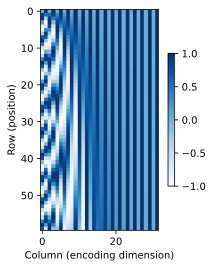

In [10]:
# 在二进制表示中，较高位的交替频率低于较低位，与下面的热图相似，只是位置编码通过使用三角函数在编码维度上降低频率
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

2.相对位置信息<br>
对任何确定的位置偏移$\delta$，位置$i+\delta$处的位置编码可以用线性投影位置i处的位置编码来表示